In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.offline import iplot,init_notebook_mode
from IPython.display import HTML

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
import keras 
from keras.models import Sequential
from keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import MaxPooling2D, Flatten, Dense,BatchNormalization,GlobalAveragePooling2D,Conv2D,Dropout,Flatten,Rescaling,Input
from keras import regularizers
from keras.callbacks import EarlyStopping,ModelCheckpoint

import os
import random
import cv2

2025-04-17 15:08:39.462996: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744902519.694365      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744902519.762635      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
data_path = "/kaggle/input/mango-leaf-disease-dataset"
img_size = (224,224)
batch_size = 32
mode = "rgb"
epochs = 40

In [3]:
def df_maker(path):
    file_paths = []
    labels = []

    folds = os.listdir(path)
    for fold in folds:
        fold_path = os.path.join(path,fold)
        file_list = os.listdir(fold_path)
        for file in file_list:
            file_path = os.path.join(fold_path,file)
            file_paths.append(file_path)
            labels.append(fold)


    file_series = pd.Series(file_paths,name="file_paths")
    label_series = pd.Series(labels,name="labels")

    df = pd.concat([file_series,label_series],axis=1)
    return df

In [4]:
df = df_maker(data_path)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   file_paths  4000 non-null   object
 1   labels      4000 non-null   object
dtypes: object(2)
memory usage: 62.6+ KB


In [6]:
train_df,test_df= train_test_split(df ,train_size= 0.75, shuffle= True, random_state= 7, stratify=df["labels"])

In [7]:
test_df,val_df= train_test_split(test_df ,train_size= 0.5, shuffle= True, random_state= 7, stratify=test_df["labels"])

In [8]:
train_df

,file_paths,labels
2370,/kaggle/input/mango-leaf-disease-dataset/Sooty...,Sooty Mould
1065,/kaggle/input/mango-leaf-disease-dataset/Anthr...,Anthracnose
334,/kaggle/input/mango-leaf-disease-dataset/Powde...,Powdery Mildew
899,/kaggle/input/mango-leaf-disease-dataset/Cutti...,Cutting Weevil
3907,/kaggle/input/mango-leaf-disease-dataset/Die B...,Die Back
...,...,...
2984,/kaggle/input/mango-leaf-disease-dataset/Gall ...,Gall Midge
2756,/kaggle/input/mango-leaf-disease-dataset/Gall ...,Gall Midge
3436,/kaggle/input/mango-leaf-disease-dataset/Healt...,Healthy
1884,/kaggle/input/mango-leaf-disease-dataset/Bacte...,Bacterial Canker


In [9]:
test_df

,file_paths,labels
3312,/kaggle/input/mango-leaf-disease-dataset/Healt...,Healthy
24,/kaggle/input/mango-leaf-disease-dataset/Powde...,Powdery Mildew
2167,/kaggle/input/mango-leaf-disease-dataset/Sooty...,Sooty Mould
1233,/kaggle/input/mango-leaf-disease-dataset/Anthr...,Anthracnose
2607,/kaggle/input/mango-leaf-disease-dataset/Gall ...,Gall Midge
...,...,...
3807,/kaggle/input/mango-leaf-disease-dataset/Die B...,Die Back
3878,/kaggle/input/mango-leaf-disease-dataset/Die B...,Die Back
3633,/kaggle/input/mango-leaf-disease-dataset/Die B...,Die Back
1792,/kaggle/input/mango-leaf-disease-dataset/Bacte...,Bacterial Canker


In [10]:
val_df

,file_paths,labels
2814,/kaggle/input/mango-leaf-disease-dataset/Gall ...,Gall Midge
3103,/kaggle/input/mango-leaf-disease-dataset/Healt...,Healthy
503,/kaggle/input/mango-leaf-disease-dataset/Cutti...,Cutting Weevil
3333,/kaggle/input/mango-leaf-disease-dataset/Healt...,Healthy
1043,/kaggle/input/mango-leaf-disease-dataset/Anthr...,Anthracnose
...,...,...
1054,/kaggle/input/mango-leaf-disease-dataset/Anthr...,Anthracnose
2831,/kaggle/input/mango-leaf-disease-dataset/Gall ...,Gall Midge
2743,/kaggle/input/mango-leaf-disease-dataset/Gall ...,Gall Midge
1189,/kaggle/input/mango-leaf-disease-dataset/Anthr...,Anthracnose


In [11]:
df.labels.value_counts()

labels
Powdery Mildew      500
Cutting Weevil      500
Anthracnose         500
Bacterial Canker    500
Sooty Mould         500
Gall Midge          500
Healthy             500
Die Back            500
Name: count, dtype: int64

In [12]:
df.labels.value_counts().head()

labels
Powdery Mildew      500
Cutting Weevil      500
Anthracnose         500
Bacterial Canker    500
Sooty Mould         500
Name: count, dtype: int64

In [13]:

df_plot = df.labels.value_counts().reset_index()
df_plot.columns = ['labels', 'count']  # Đặt tên cột rõ ràng

# Vẽ biểu đồ
fig1 = px.bar(
    data_frame=df_plot,
    x="labels",
    y="count",
    title="Number of images for each class in train data",
    template="plotly_dark"
)
HTML(fig1.to_html(include_plotlyjs='cdn'))

In [14]:
train_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()

In [15]:
train_data = train_datagen.flow_from_dataframe(
    train_df,
    x_col = "file_paths",
    y_col = "labels",
    target_size=img_size,
    color_mode= mode,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
)
test_data = test_datagen.flow_from_dataframe(
    test_df,
    x_col = "file_paths",
    y_col = "labels",
    target_size=img_size,
    color_mode= mode,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False,
)
val_data = val_datagen.flow_from_dataframe(
    val_df,
    x_col = "file_paths",
    y_col = "labels",
    target_size=img_size,
    color_mode= mode,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
)

Found 3000 validated image filenames belonging to 8 classes.
Found 500 validated image filenames belonging to 8 classes.
Found 500 validated image filenames belonging to 8 classes.


In [16]:
print("Thứ tự nhãn từ train_generator:", train_data.class_indices)

Thứ tự nhãn từ train_generator: {'Anthracnose': 0, 'Bacterial Canker': 1, 'Cutting Weevil': 2, 'Die Back': 3, 'Gall Midge': 4, 'Healthy': 5, 'Powdery Mildew': 6, 'Sooty Mould': 7}


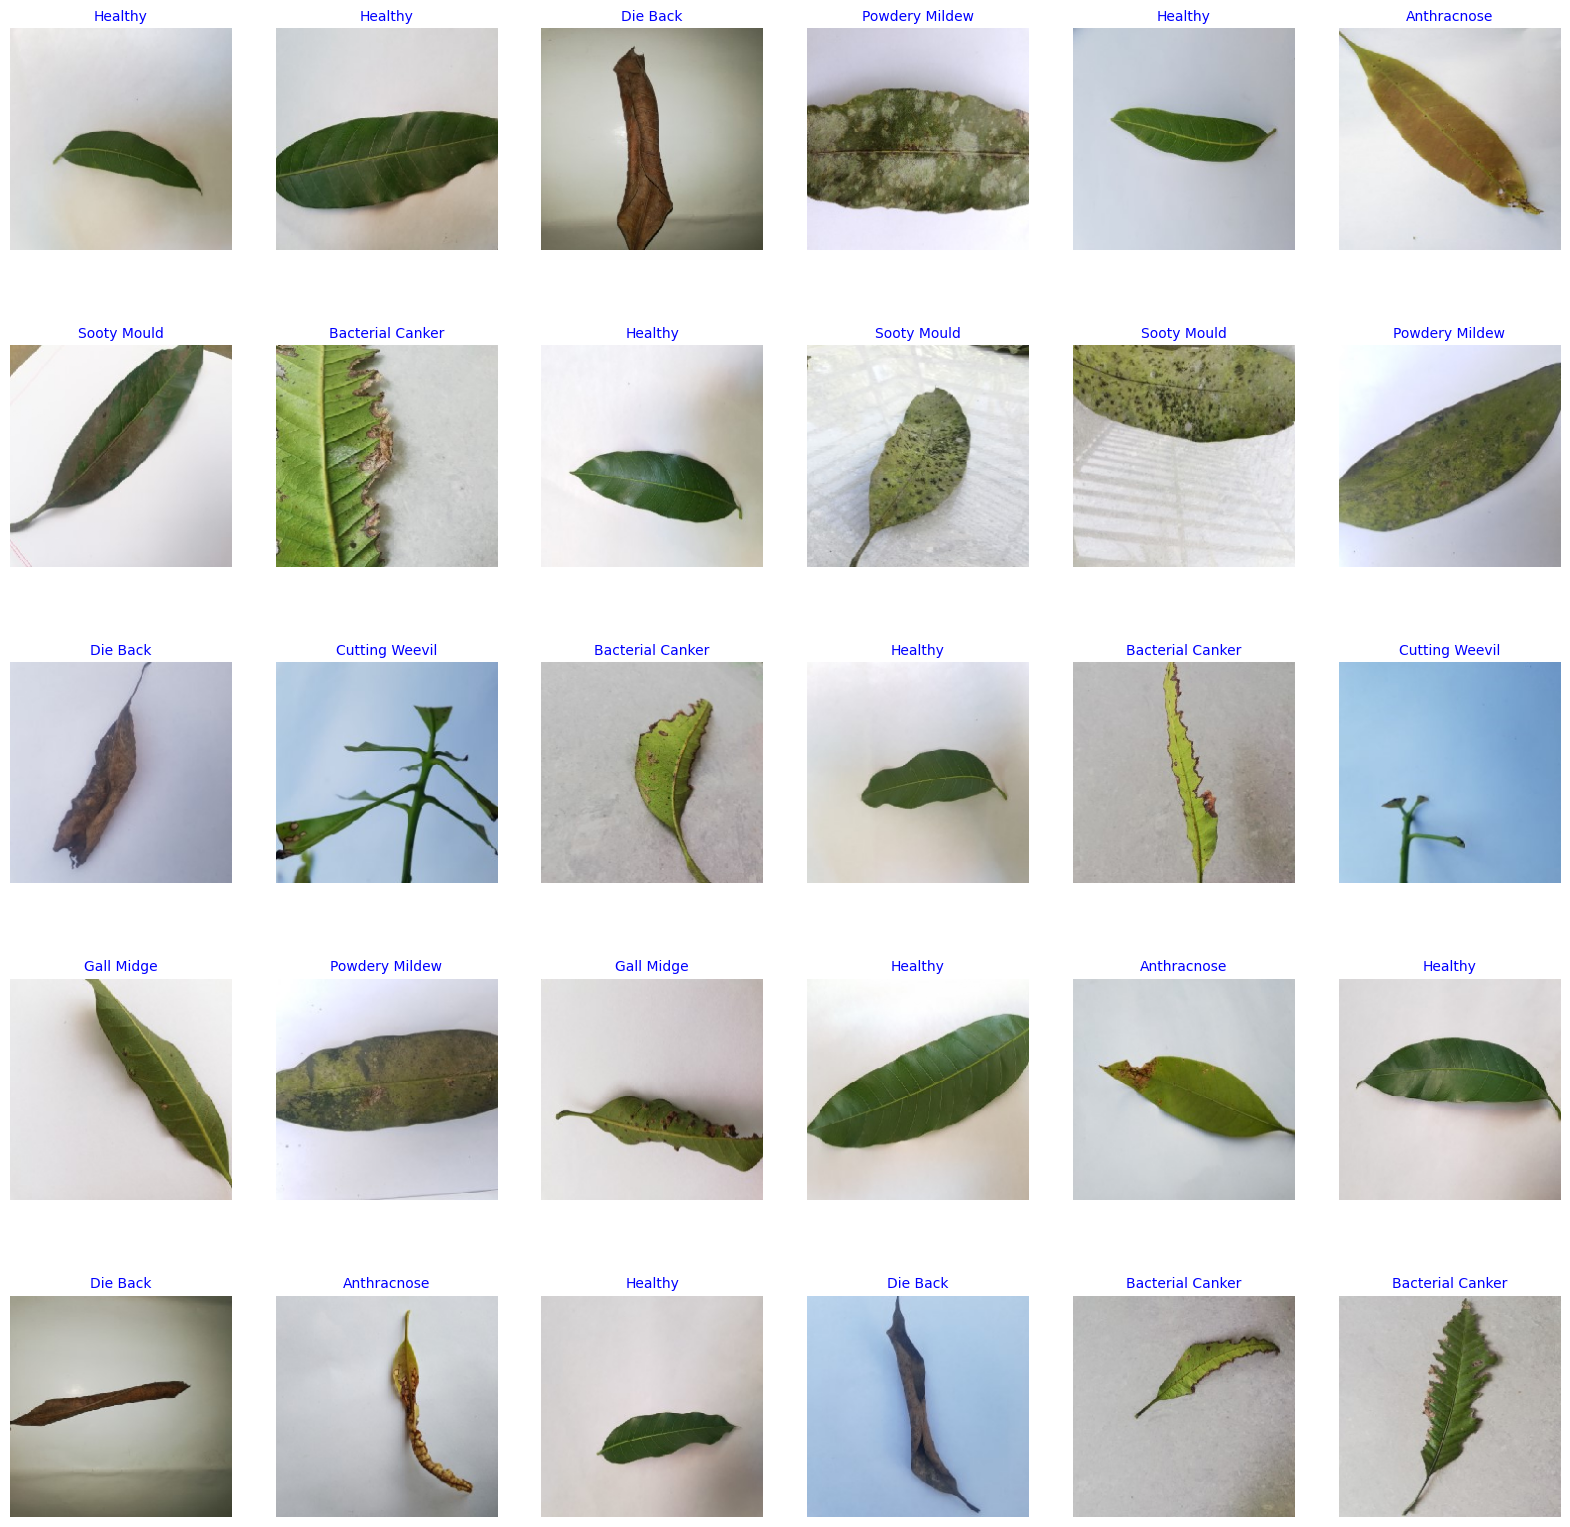

In [17]:
g_dict = train_data.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_data)      # get a batch size samples from the generator
# # difference between next iterator and for iterator


plt.figure(figsize= (20, 24))

for i in range(30):
    plt.subplot(6, 6, i + 1)
    image = images[i]/255
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 10)
    plt.axis('off')

In [18]:
base_model_1  = tf.keras.applications.EfficientNetB5(weights = "/kaggle/input/efficientnetb5-notop/efficientnetb5_notop.h5", include_top = False, pooling = "max")

I0000 00:00:1744902545.959426      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [19]:
base_model_1.trainable = False

efficientnet_model = Sequential([
    Input(shape = (224,224,3)),
    base_model_1,
    Dropout(0.2),
    
    BatchNormalization(),
    Dense(256, activation= 'relu',kernel_regularizer= regularizers.l2(0.016)),
    Dropout(0.2, seed = 7),
    Dense(256, activation= 'relu',kernel_regularizer= regularizers.l2(0.016)),
    Dropout(0.2, seed = 7),
    
    Dense(8, activation= 'softmax')
])


efficientnet_model.compile(optimizer = keras.optimizers.Adamax(learning_rate = 0.001), loss="categorical_crossentropy",metrics=["accuracy"])

In [20]:
efficientnet_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb5 (Functional)          │ (None, 2048)                │      28,513,527 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 2048)                │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,114,111 (111.06 MB)

 Trainable params: 596,488 (2.28 MB)

 Non-trainable params: 28,517,623 (108.79 MB)

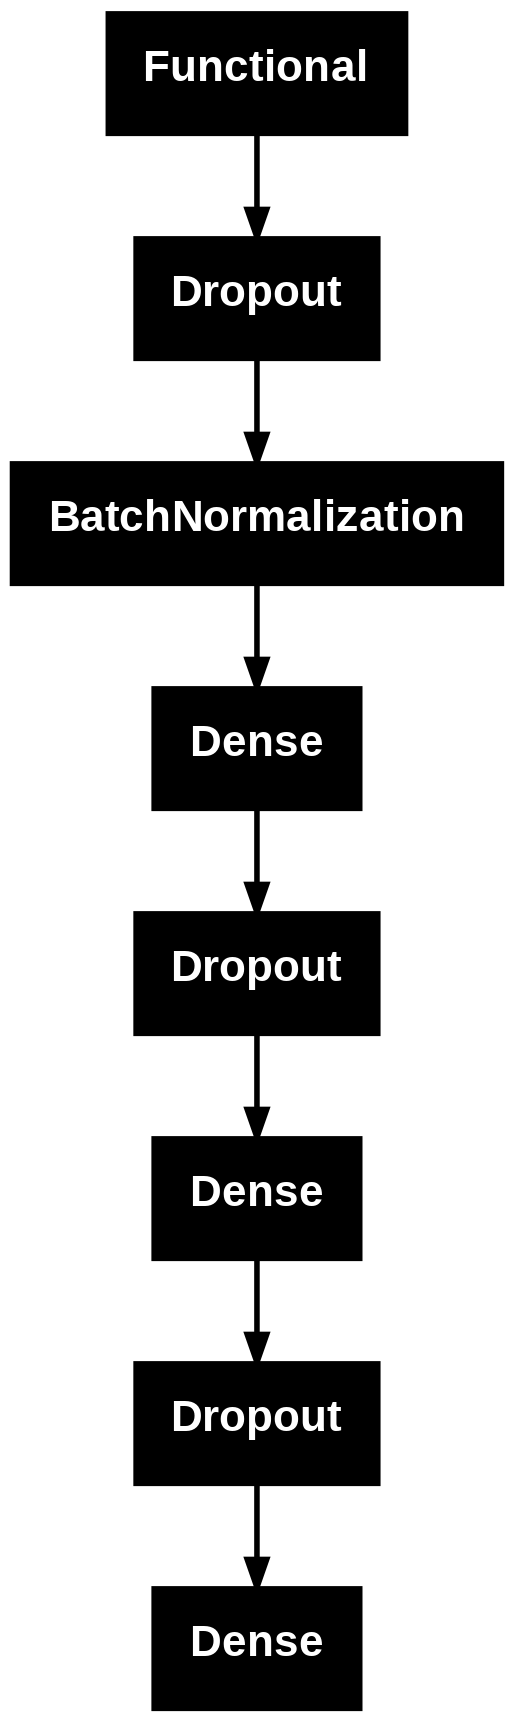

In [21]:
from keras.utils import plot_model
plot_model(efficientnet_model)

In [22]:
check_point = ModelCheckpoint('efficientNet_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')
early_stopping =EarlyStopping(monitor='val_accuracy',patience=10, restore_best_weights=True, mode='max')

In [23]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(train_data.classes),
                                     y=train_data.classes)
class_weights_dict = dict(enumerate(class_weights))

In [24]:
history = efficientnet_model.fit(train_data,epochs = epochs, validation_data = val_data, callbacks = [check_point,early_stopping],class_weight=class_weights_dict)

Epoch 1/40


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.

I0000 00:00:1744902594.915570      64 service.cc:148] XLA service 0x790298004260 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744902594.916470      64 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1744902599.566974      64 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/94 ━━━━━━━━━━━━━━━━━━━━ 1:48:49 70s/step - accuracy: 0.1562 - loss: 13.9533

I0000 00:00:1744902623.852895      64 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


94/94 ━━━━━━━━━━━━━━━━━━━━ 136s 709ms/step - accuracy: 0.5554 - loss: 11.7658 - val_accuracy: 0.8080 - val_loss: 8.9618
Epoch 2/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 0.8293 - loss: 8.4121 - val_accuracy: 0.8900 - val_loss: 6.7112
Epoch 3/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 12s 125ms/step - accuracy: 0.8738 - loss: 6.3928 - val_accuracy: 0.9420 - val_loss: 5.0612
Epoch 4/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.8914 - loss: 4.8880 - val_accuracy: 0.9520 - val_loss: 3.8627
Epoch 5/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - accuracy: 0.9056 - loss: 3.7536 - val_accuracy: 0.9740 - val_loss: 2.9515
Epoch 6/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - accuracy: 0.9214 - loss: 2.9013 - val_accuracy: 0.9680 - val_loss: 2.2848
Epoch 7/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - accuracy: 0.9212 - loss: 2.2794 - val_accuracy: 0.9700 - val_loss: 1.7917
Epoch 8/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - accuracy: 0.9347 - loss: 1.7899 - val_accuracy: 0.9

In [25]:
vals = pd.DataFrame(history.history)
vals = vals.rename(columns={"loss":"Train Loss","val_loss":"Validation Loss","accuracy":"Train Accuracy","val_accuracy":"Validation Accuracy"})

In [26]:
fig2a = px.line(data_frame=vals,
              y = ["Train Loss","Validation Loss"],
              labels={"index":"epochs","value":"loss"},
              title = "Losses",
              template="plotly_dark")
HTML(fig2a.to_html(include_plotlyjs='cdn'))

In [27]:
fig2b = px.line(data_frame=vals,
              y = ["Train Accuracy","Validation Accuracy"],
              labels={"index":"epochs","value":"accuracy"},
              title = "Accuracy",
              template="plotly_dark")
HTML(fig2b.to_html(include_plotlyjs='cdn'))

In [28]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = efficientnet_model.evaluate(train_data, steps= test_steps, verbose= 1)
valid_score = efficientnet_model.evaluate(val_data, steps= test_steps, verbose= 1)
test_score = efficientnet_model.evaluate(test_data, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accurary: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.9765 - loss: 1.1120
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.9942 - loss: 1.1013
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - accuracy: 0.9688 - loss: 1.0956

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 0.9687 - loss: 1.1278
Train Loss:  1.1097304821014404
Train Accurary:  0.9781249761581421
--------------------
Validation Loss:  1.1221586465835571
Validation Accuracy:  0.981249988079071
--------------------
Test Loss:  1.1262788772583008
Test Accuracy:  0.9750000238418579


In [29]:
print(f"Số ảnh trong test_data: {test_data.n}")

Số ảnh trong test_data: 500


In [30]:

predictions = efficientnet_model.predict(test_data) 
y_pred = np.argmax(predictions, axis = 1)
y_true = test_data.classes

16/16 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step


In [31]:
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.96      0.86      0.91        63
           1       1.00      1.00      1.00        62
           2       1.00      1.00      1.00        63
           3       0.98      0.97      0.98        62
           4       0.91      0.97      0.94        62
           5       0.95      1.00      0.98        63
           6       0.97      0.97      0.97        63
           7       0.94      0.95      0.94        62

    accuracy                           0.96       500
   macro avg       0.96      0.96      0.96       500
weighted avg       0.96      0.96      0.96       500



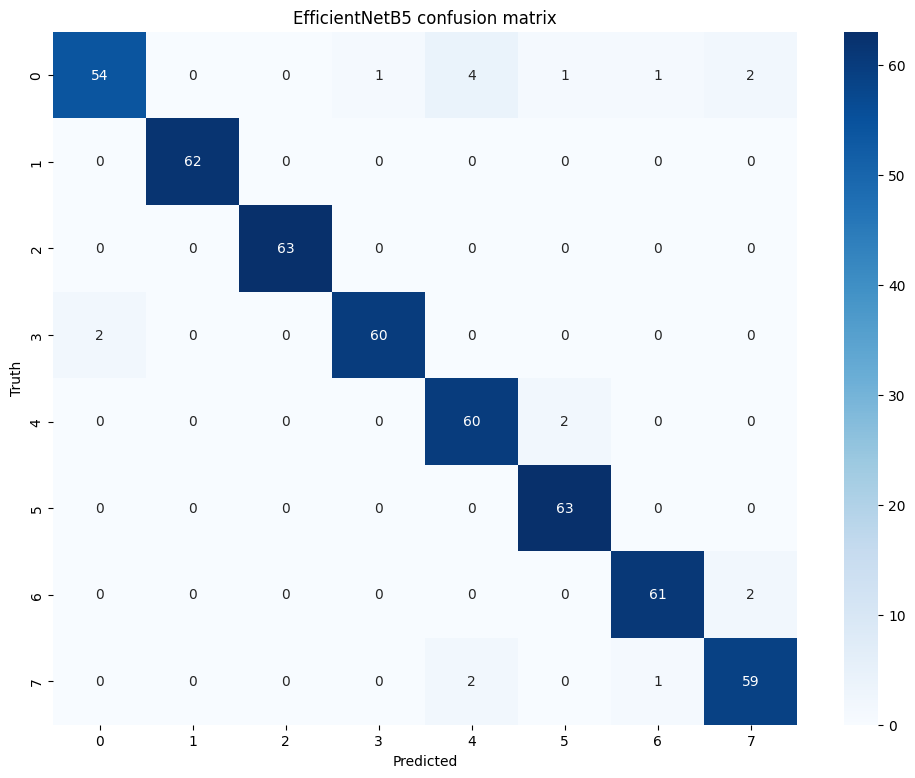

In [32]:
plt.figure(figsize = (12,9))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True,fmt='d',cmap= plt.cm.Blues)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title("EfficientNetB5 confusion matrix")
plt.show()

In [33]:
efficientnet_model.save('efficientnet_model.h5')

In [34]:
!pip install onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 96.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 5.6 MB/s eta 0:00:00


In [35]:

pip install tf2onnx onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.8/455.8 kB 16.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [36]:
import tensorflow as tf
import tf2onnx

# Load mô hình Keras từ file .h5
model = tf.keras.models.load_model("efficientnet_model.h5")

# Định nghĩa input shape phù hợp với mô hình của bạn
spec = (tf.TensorSpec((None, 224, 224, 3), tf.float32, name="input_layer_1"),)  # chỉnh lại nếu khác

# Convert sang ONNX
model_proto, _ = tf2onnx.convert.from_function(
    tf.function(model),  # wrap model
    input_signature=spec,
    opset=13,
    output_path="my_model.onnx"
)

print("✅ Chuyển đổi sang ONNX thành công!")

I0000 00:00:1744902943.238347      19 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
I0000 00:00:1744902943.238534      19 single_machine.cc:361] Starting new session
I0000 00:00:1744902943.239631      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
I0000 00:00:1744902954.292645      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
I0000 00:00:1744902957.019419      19 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
I0000 00:00:1744902957.019667      19 single_machine.cc:361] Starting new session
I0000 00:00:1744902957.020883      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 wi

✅ Chuyển đổi sang ONNX thành công!


[1] ✅ True: Healthy | 🤖 Keras: Healthy | 🤖 ONNX: Healthy


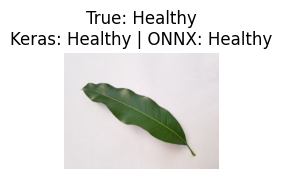

[2] ✅ True: Anthracnose | 🤖 Keras: Anthracnose | 🤖 ONNX: Anthracnose


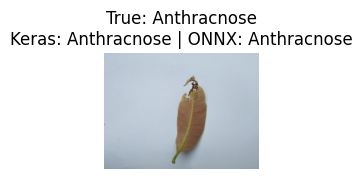

[3] ✅ True: Sooty Mould | 🤖 Keras: Sooty Mould | 🤖 ONNX: Sooty Mould


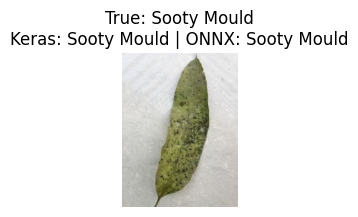

[4] ✅ True: Anthracnose | 🤖 Keras: Anthracnose | 🤖 ONNX: Anthracnose


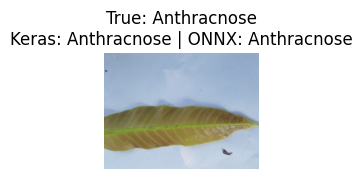

[5] ✅ True: Gall Midge | 🤖 Keras: Gall Midge | 🤖 ONNX: Gall Midge


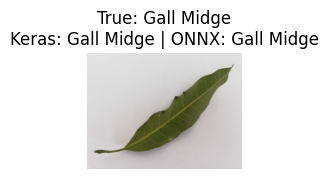

[6] ✅ True: Bacterial Canker | 🤖 Keras: Bacterial Canker | 🤖 ONNX: Bacterial Canker


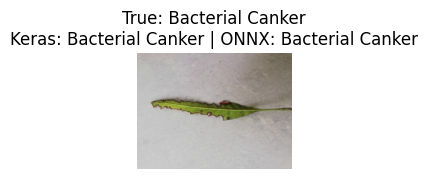

[7] ✅ True: Bacterial Canker | 🤖 Keras: Bacterial Canker | 🤖 ONNX: Bacterial Canker


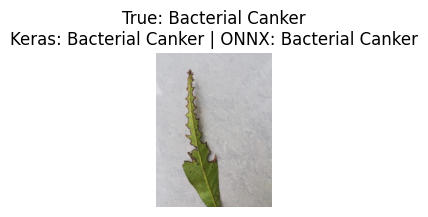

[8] ✅ True: Die Back | 🤖 Keras: Die Back | 🤖 ONNX: Die Back


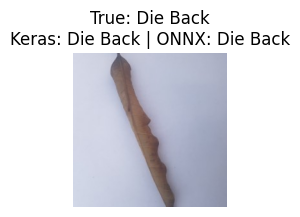

[9] ✅ True: Gall Midge | 🤖 Keras: Gall Midge | 🤖 ONNX: Gall Midge


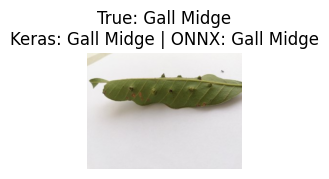

[10] ✅ True: Gall Midge | 🤖 Keras: Gall Midge | 🤖 ONNX: Gall Midge


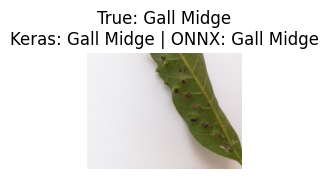


✅ Accuracy (Keras): 10/10 (100.00%)
✅ Accuracy (ONNX): 10/10 (100.00%)

📊 Classification Report (Keras):
                  precision    recall  f1-score   support

     Anthracnose       1.00      1.00      1.00         2
Bacterial Canker       1.00      1.00      1.00         2
        Die Back       1.00      1.00      1.00         1
      Gall Midge       1.00      1.00      1.00         3
         Healthy       1.00      1.00      1.00         1
     Sooty Mould       1.00      1.00      1.00         1

        accuracy                           1.00        10
       macro avg       1.00      1.00      1.00        10
    weighted avg       1.00      1.00      1.00        10


📊 Classification Report (ONNX):
                  precision    recall  f1-score   support

     Anthracnose       1.00      1.00      1.00         2
Bacterial Canker       1.00      1.00      1.00         2
        Die Back       1.00      1.00      1.00         1
      Gall Midge       1.00      1.00      1.

In [37]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input
import onnxruntime as ort
# Load Keras model
efficientnet_model = load_model('/kaggle/working/efficientnet_model.h5')

# Load ONNX session
onnx_session = ort.InferenceSession("/kaggle/working/my_model.onnx")

# Số ảnh muốn kiểm tra
total = 10
correct_keras = 0
correct_onnx = 0

# Lấy ngẫu nhiên 20 ảnh từ test_df
sample_df = test_df.sample(n=total).reset_index(drop=True)

# Lấy ánh xạ class
class_indices = train_data.class_indices
index_to_class = {v: k for k, v in class_indices.items()}
class_labels = list(class_indices.keys())

# Danh sách để đánh giá
y_true = []
y_pred_keras = []
y_pred_onnx = []

# Duyệt qua 20 ảnh
for i in range(total):
    img_path = sample_df.iloc[i]['file_paths']
    true_label = sample_df.iloc[i]['labels']

    # Load và preprocess ảnh
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_exp = np.expand_dims(img_array, axis=0)
    
    # --- Dự đoán với Keras model ---
    keras_input = preprocess_input(img_array_exp.copy())
    prediction_keras = efficientnet_model.predict(keras_input, verbose=0)
    pred_idx_keras = np.argmax(prediction_keras)
    pred_label_keras = index_to_class[pred_idx_keras]
    
    # --- Dự đoán với ONNX model ---
    onnx_input = img_array_exp.astype(np.float32)
    mean = np.array([[[[0.485, 0.456, 0.406]]]], dtype=np.float32)
    std = np.array([[[[0.229, 0.224, 0.225]]]], dtype=np.float32)

    input_names = [inp.name for inp in onnx_session.get_inputs()]
    inputs = {
        input_names[0]: onnx_input,
        input_names[1]: mean,
        input_names[2]: std,
    }

    pred_onx = onnx_session.run(None, inputs)
    pred_idx_onnx = np.argmax(pred_onx[0])
    pred_label_onnx = class_labels[pred_idx_onnx]

    # Đếm đúng
    if pred_label_keras == true_label:
        correct_keras += 1
    if pred_label_onnx == true_label:
        correct_onnx += 1

    # Lưu kết quả
    y_true.append(true_label)
    y_pred_keras.append(pred_label_keras)
    y_pred_onnx.append(pred_label_onnx)

    # In ra kết quả
    print(f"[{i+1}] ✅ True: {true_label} | 🤖 Keras: {pred_label_keras} | 🤖 ONNX: {pred_label_onnx}")

    # Hiển thị ảnh
    plt.figure(figsize=(2, 2))
    plt.imshow(image.load_img(img_path))
    plt.title(f"True: {true_label}\nKeras: {pred_label_keras} | ONNX: {pred_label_onnx}")
    plt.axis('off')
    plt.show()

# Tính độ chính xác
print(f"\n✅ Accuracy (Keras): {correct_keras}/{total} ({(correct_keras/total)*100:.2f}%)")
print(f"✅ Accuracy (ONNX): {correct_onnx}/{total} ({(correct_onnx/total)*100:.2f}%)")

# Classification report
print("\n📊 Classification Report (Keras):")
print(classification_report(y_true, y_pred_keras))

print("\n📊 Classification Report (ONNX):")
print(classification_report(y_true, y_pred_onnx)) 

In [38]:
session = ort.InferenceSession("/kaggle/working/my_model.onnx")

for input_tensor in session.get_inputs():
    print("🟡 Input name:", input_tensor.name)
    print("   Shape     :", input_tensor.shape)
    print("   Type      :", input_tensor.type)

🟡 Input name: input_layer_1
   Shape     : ['unk__3416', 224, 224, 3]
   Type      : tensor(float)
🟡 Input name: sequential_1/efficientnetb5_1/normalization_1/Sub/y:0
   Shape     : [1, 1, 1, 3]
   Type      : tensor(float)
🟡 Input name: sequential_1/efficientnetb5_1/normalization_1/Sqrt/x:0
   Shape     : [1, 1, 1, 3]
   Type      : tensor(float)


In [39]:
print(session.get_inputs()[0].name)

input_layer_1


In [40]:

from PIL import Image
class_labels = ['Anthracnose', 'Bacterial Canker', 'Cutting Weevil',
            'Die Back', 'Gall Midge', 'Healthy', 'Powdery Mildew', 'Sooty Mould']
def preprocess_image(img_path):
    img = Image.open(img_path).resize((224, 224))
    img = np.asarray(img).astype(np.float32) 
    img = np.expand_dims(img, axis=0)  # [1, 224, 224, 3]
    return img

# Tạo mean và std với đúng shape
mean = np.array([[[[0.485, 0.456, 0.406]]]], dtype=np.float32)  # [1,1,1,3]
std = np.array([[[[0.229, 0.224, 0.225]]]], dtype=np.float32)   # [1,1,1,3]

# Load model
session = ort.InferenceSession("my_model.onnx")

# Lấy tên input từ mô hình (chính xác)
input_names = [i.name for i in session.get_inputs()]
print("Inputs:", input_names)

# Load ảnh
img_tensor = preprocess_image("/kaggle/input/mango-leaf-disease-dataset/Cutting Weevil/20211011_131104 (Custom) (Custom).jpg")

# Tạo dictionary đúng key
inputs = {
    input_names[0]: img_tensor,  # ảnh
    input_names[1]: mean,        # mean
    input_names[2]: std          # std
}

# Dự đoán
output = session.run(None, inputs)
pred = np.argmax(output[0])
pred_label = class_labels[pred]

# Print prediction
print("✅ Predicted class index:", pred)
print("🟢 Predicted label:", pred_label)

Inputs: ['input_layer_1', 'sequential_1/efficientnetb5_1/normalization_1/Sub/y:0', 'sequential_1/efficientnetb5_1/normalization_1/Sqrt/x:0']
✅ Predicted class index: 2
🟢 Predicted label: Cutting Weevil


In [41]:
import onnxruntime as ort
import numpy as np


image_path = "/kaggle/input/mango-leaf-disease-dataset/Powdery Mildew/20211109_121452 (Custom).jpg"
img = Image.open(image_path).resize((224, 224))
img = np.array(img).astype(np.float32) 
img = np.expand_dims(img, axis=0)  # [1, 224, 224, 3]

# Optional: apply normalization
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
img_norm = (img - mean) / std  # broadcast sẽ tự xử lý

# Nếu model cần 3 input
mean_tensor = mean.reshape(1, 1, 1, 3).astype(np.float32)
std_tensor = std.reshape(1, 1, 1, 3).astype(np.float32)

session = ort.InferenceSession("my_model.onnx")
input_name = session.get_inputs()[0].name
print("Input name:", input_name)

inputs = {
    "input_layer_1": img,  # hoặc img_norm nếu cần
    "sequential_1/efficientnetb5_1/normalization_1/Sub/y:0": mean_tensor,
    "sequential_1/efficientnetb5_1/normalization_1/Sqrt/x:0": std_tensor
}

outputs = session.run(None, inputs)
pred = outputs[0].squeeze()
print("Top prediction index:", np.argmax(pred))
print("Scores:", pred)

Input name: input_layer_1
Top prediction index: 6
Scores: [1.3617067e-04 1.2633430e-05 1.0746462e-05 8.2073071e-05 1.0586278e-04
 9.1779257e-05 9.9772829e-01 1.8323845e-03]


In [42]:
base_model_2 = tf.keras.applications.ResNet50(weights = "/kaggle/input/resnet500/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5",include_top = False)

In [43]:
base_model_2.trainable = False

resnet_model = Sequential([
    Input(shape = (224,224,3)),
    base_model_2,
    GlobalAveragePooling2D(),
    Dense(256,activation = "relu",kernel_regularizer= regularizers.l2(0.016) ),
    Dropout(0.2),
    Dense(8,activation = "softmax")
])

resnet_model.compile(optimizer= Adamax(learning_rate = 0.001), loss ="categorical_crossentropy", metrics = ["accuracy"])

resnet_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,114,312 (91.99 MB)

 Trainable params: 526,600 (2.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [44]:
check_point = ModelCheckpoint('resnet_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')
early_stopping =EarlyStopping(monitor='val_accuracy',patience=5, restore_best_weights=True, mode='max')

In [45]:
history = resnet_model.fit(train_data,validation_data = val_data, epochs = epochs, callbacks = [early_stopping,check_point])

Epoch 1/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 35s 213ms/step - accuracy: 0.7802 - loss: 6.4071 - val_accuracy: 0.9900 - val_loss: 3.3695
Epoch 2/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - accuracy: 0.9869 - loss: 3.0027 - val_accuracy: 0.9960 - val_loss: 2.1102
Epoch 3/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - accuracy: 0.9919 - loss: 1.9308 - val_accuracy: 0.9940 - val_loss: 1.4416
Epoch 4/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.9928 - loss: 1.3313 - val_accuracy: 0.9900 - val_loss: 1.0346
Epoch 5/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.9951 - loss: 0.9549 - val_accuracy: 0.9880 - val_loss: 0.7605
Epoch 6/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 0.9962 - loss: 0.7034 - val_accuracy: 0.9900 - val_loss: 0.5745
Epoch 7/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.9980 - loss: 0.5320 - val_accuracy: 0.9940 - val_loss: 0.4362


In [46]:
resnet_model.evaluate(test_data)
resnet_model.save('resnet_model.h5')


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9848 - loss: 2.1354


In [47]:
vals = pd.DataFrame(history.history)
vals = vals.rename(columns={"loss":"Train Loss","val_loss":"Validation Loss","accuracy":"Train Accuracy","val_accuracy":"Validation Accuracy"})

In [48]:
fig3a = px.line(data_frame=vals,
              y = ["Train Loss","Validation Loss"],
              labels={"index":"epochs","value":"loss"},
              title = "Losses",
              template="plotly_dark")
HTML(fig3a.to_html(include_plotlyjs='cdn'))

In [49]:
fig3b = px.line(data_frame=vals,
              y = ["Train Accuracy","Validation Accuracy"],
              labels={"index":"epochs","value":"accuracy"},
              title = "Accuracy",
              template="plotly_dark")
HTML(fig3b.to_html(include_plotlyjs='cdn'))

In [50]:
predictions = resnet_model.predict(test_data) 
y_pred = np.argmax(predictions, axis = 1)
y_true = test_data.classes

16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 331ms/step


In [51]:
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98        63
           1       1.00      1.00      1.00        62
           2       1.00      1.00      1.00        63
           3       1.00      0.98      0.99        62
           4       0.97      0.95      0.96        62
           5       0.97      1.00      0.98        63
           6       0.95      1.00      0.98        63
           7       1.00      0.95      0.98        62

    accuracy                           0.98       500
   macro avg       0.98      0.98      0.98       500
weighted avg       0.98      0.98      0.98       500



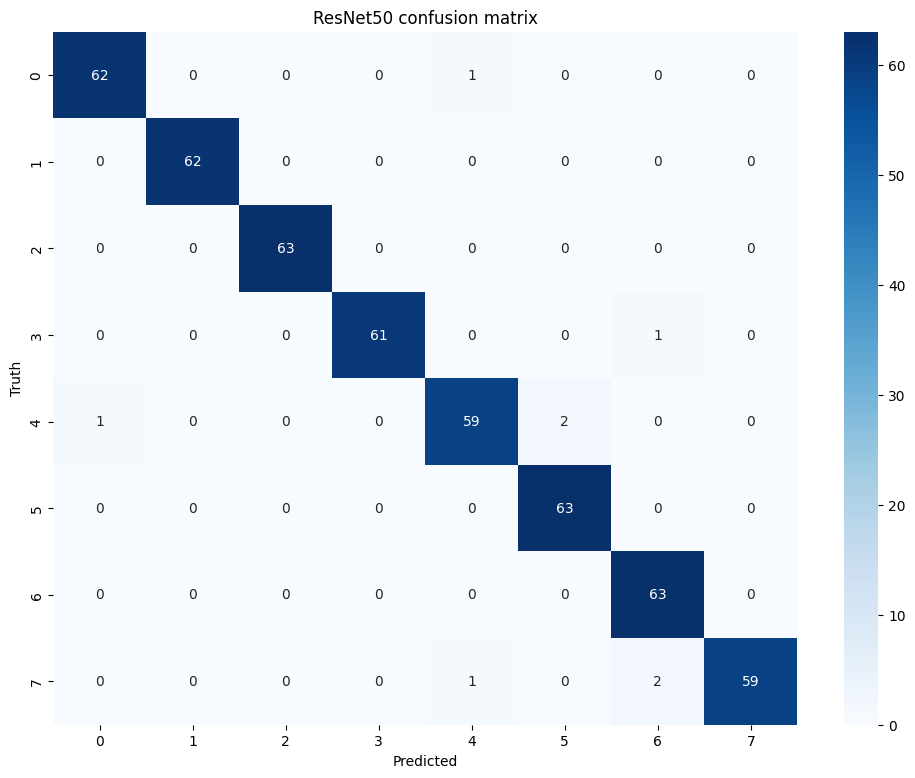

In [52]:
plt.figure(figsize = (12,9))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True,fmt='d',cmap= plt.cm.Blues)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title("ResNet50 confusion matrix")
plt.show()

3rd Model: MobileNetV2

In [53]:
base_model_3 = tf.keras.applications.MobileNetV2(weights = "/kaggle/input/mobile/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5", include_top = False, pooling = "max")

In [54]:
base_model_3.trainable = False

mobilenet_model = Sequential([
    Input(shape=(224,224,3)),
    base_model_3,
    Dropout(0.4),
    Dense(128,activation = "relu",kernel_regularizer = regularizers.l2(0.0016)),
    Dense(128,activation = "relu",kernel_regularizer = regularizers.l2(0.0016)),
    Dropout(0.4),
    Dense(8,activation = "softmax")
    
])

mobilenet_model.compile(optimizer = Adamax(learning_rate = 0.001),loss = "categorical_crossentropy", metrics= ["accuracy"])

mobilenet_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_None (Functional)   │ (None, 1280)                │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,439,496 (9.31 MB)

 Trainable params: 181,512 (709.03 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [55]:
check_point = ModelCheckpoint('mobilenet_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')

In [56]:
history = mobilenet_model.fit(train_data,validation_data = val_data, epochs = 25, callbacks = [check_point])

Epoch 1/25
94/94 ━━━━━━━━━━━━━━━━━━━━ 31s 186ms/step - accuracy: 0.2277 - loss: 3.6293 - val_accuracy: 0.5500 - val_loss: 1.9667
Epoch 2/25
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - accuracy: 0.3932 - loss: 2.1811 - val_accuracy: 0.6820 - val_loss: 1.5481
Epoch 3/25
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.5007 - loss: 1.9073 - val_accuracy: 0.7300 - val_loss: 1.3676
Epoch 4/25
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - accuracy: 0.6072 - loss: 1.6297 - val_accuracy: 0.7760 - val_loss: 1.1905
Epoch 5/25
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - accuracy: 0.6255 - loss: 1.5336 - val_accuracy: 0.8040 - val_loss: 1.1259
Epoch 6/25
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - accuracy: 0.6932 - loss: 1.3480 - val_accuracy: 0.7940 - val_loss: 1.0785
Epoch 7/25
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.7009 - loss: 1.3555 - val_accuracy: 0.8180 - val_loss: 1.0069
Epoch 8/25
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - accuracy: 0.7339 - loss: 1.2364 - val_accuracy: 0.8540 -

In [57]:
mobilenet_model.evaluate(test_data)
mobilenet_model.save('mobilenet_model.h5')


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.9336 - loss: 0.5739


In [58]:
vals = pd.DataFrame(history.history)
vals = vals.rename(columns={"loss":"Train Loss","val_loss":"Validation Loss","accuracy":"Train Accuracy","val_accuracy":"Validation Accuracy"})

In [59]:
fig4a = px.line(data_frame=vals,
              y = ["Train Loss","Validation Loss"],
              labels={"index":"epochs","value":"loss"},
              title = "Losses",
              template="plotly_dark")
HTML(fig4a.to_html(include_plotlyjs='cdn'))

In [60]:
fig4b = px.line(data_frame=vals,
              y = ["Train Accuracy","Validation Accuracy"],
              labels={"index":"epochs","value":"accuracy"},
              title = "Accuracy",
              template="plotly_dark")
HTML(fig4b.to_html(include_plotlyjs='cdn'))

In [61]:
predictions = mobilenet_model.predict(test_data) 
y_pred = np.argmax(predictions, axis = 1)
y_true = test_data.classes

16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 279ms/step


In [62]:
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89        63
           1       0.95      1.00      0.98        62
           2       1.00      1.00      1.00        63
           3       0.94      0.94      0.94        62
           4       0.85      0.81      0.83        62
           5       1.00      0.98      0.99        63
           6       0.85      0.92      0.89        63
           7       0.97      0.90      0.93        62

    accuracy                           0.93       500
   macro avg       0.93      0.93      0.93       500
weighted avg       0.93      0.93      0.93       500



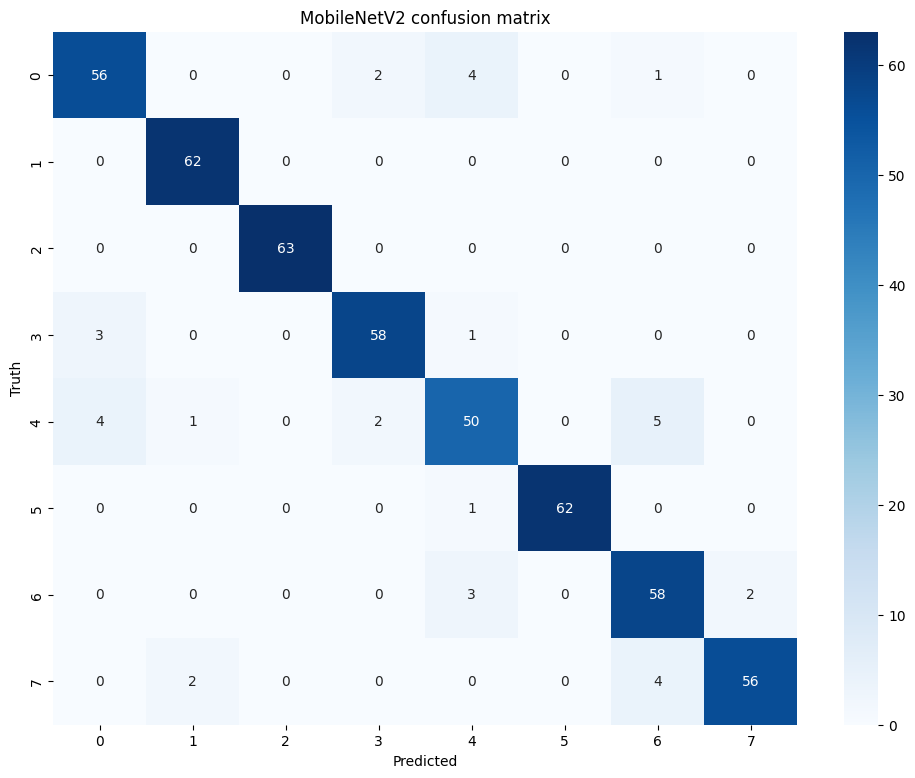

In [63]:
plt.figure(figsize = (12,9))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True,fmt='d',cmap= plt.cm.Blues)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title("MobileNetV2 confusion matrix")
plt.show()